---

<h1 style="text-align: center;font-size: 40px;">Cataract Prediction using CNN</h1>

---

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import cv2
import random
from tqdm import tqdm
import os

In [4]:
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


<h3> Extracting Cataract & Normal information from the Dataset </h3>

>Cataract Images

In [5]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: "cataract" in x)
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: "cataract" in x)

In [6]:
left_cataract = df.loc[(df.C == 1) & (df.left_cataract == 1)]["Left-Fundus"].values

In [7]:
right_cataract = df.loc[(df.C == 1) & (df.right_cataract == 1)]["Right-Fundus"].values

In [8]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


>Normal Images

In [9]:
left_normal = df.loc[(df.C == 0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(300, random_state = 42).values

In [10]:
right_normal = df.loc[(df.C == 0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(300, random_state = 42).values

In [11]:
print("Number of images in left normal: {}".format(len(left_normal)))
print("Number of images in right normal: {}".format(len(right_normal)))

Number of images in left normal: 300
Number of images in right normal: 300


>Combining Left and Right

In [12]:
cataract = np.concatenate((left_cataract, right_cataract), axis = 0)
normal = np.concatenate((left_normal, right_normal), axis = 0)

In [13]:
print("Total Cataract: ", len(cataract))
print("Total Normal: ", len(normal))

Total Cataract:  594
Total Normal:  600


<h3>Creating Dataset from images</h3>

In [14]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
image_size = 224
labels = []
dataset = []
def create_dataset(image_category, label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir, img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image, (image_size, image_size))
        except:
            continue
        dataset.append([np.array(image), np.array(label)])
    random.shuffle(dataset)
    return dataset
        

In [15]:
dataset = create_dataset(cataract, 1)

100%|██████████| 594/594 [00:03<00:00, 151.76it/s]


In [16]:
len(dataset)

588

In [17]:
dataset = create_dataset(normal,0)

100%|██████████| 600/600 [00:05<00:00, 113.33it/s]


In [18]:
len(dataset)

1188

>Let's see some images

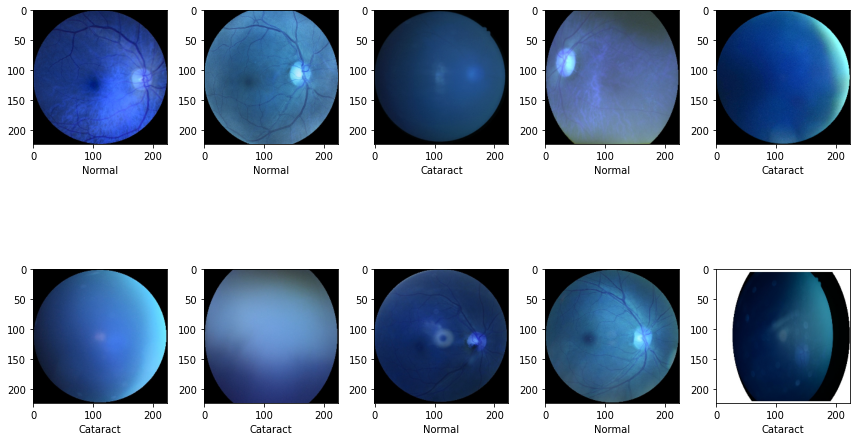

In [19]:
plt.figure(figsize = (12, 8))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category == 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

<h3>Dividing dataset into x (features) & y (label)</h3>

In [20]:
x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
y = np.array([i[1] for i in dataset])

In [21]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.3)

<h3>Creating Model</h3>

In [34]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights = "imagenet", include_top = False, input_shape = (image_size, image_size, 3))

In [35]:
for layer in vgg.layers:
    layer.trainable = False

In [36]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1, activation = "sigmoid"))

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [39]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5", monitor = "val_acc", verbose = 1, save_best_only = True, save_weights_only = False, period = 1)
earlystop = EarlyStopping(monitor = "val_acc", patience = 5, verbose = 1)

In [42]:
history = model.fit(x_train, y_train, batch_size = 32, epochs = 15, validation_data = (x_test, y_test), verbose = 1, callbacks = [checkpoint, earlystop])

Epoch 1/15
26/26 [==============================] - 4s 125ms/step - loss: 1.6250 - accuracy: 0.8893 - val_loss: 1.8462 - val_accuracy: 0.8908
Epoch 2/15
26/26 [==============================] - 3s 106ms/step - loss: 0.4363 - accuracy: 0.9591 - val_loss: 0.4212 - val_accuracy: 0.9356
Epoch 3/15
26/26 [==============================] - 3s 104ms/step - loss: 0.0914 - accuracy: 0.9807 - val_loss: 0.5242 - val_accuracy: 0.9496
Epoch 4/15
26/26 [==============================] - 3s 104ms/step - loss: 0.0189 - accuracy: 0.9928 - val_loss: 0.4282 - val_accuracy: 0.9580
Epoch 5/15
26/26 [==============================] - 3s 103ms/step - loss: 0.0091 - accuracy: 0.9976 - val_loss: 0.4093 - val_accuracy: 0.9580
Epoch 6/15
26/26 [==============================] - 3s 103ms/step - loss: 8.1726e-04 - accuracy: 1.0000 - val_loss: 0.4202 - val_accuracy: 0.9580
Epoch 7/15
26/26 [==============================] - 3s 103ms/step - loss: 7.5106e-04 - accuracy: 1.0000 - val_loss: 0.4164 - val_accuracy: 0.949

In [62]:
loss, accuracy = model.evaluate(x_test, y_test)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

12/12 [==============================] - 1s 67ms/step - loss: 0.4140 - accuracy: 0.9524
Loss:  0.41400855779647827
Accuracy:  0.9523809552192688


In [64]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
y_pred = (model.predict(x_test) >= 0.5).astype("int32")
y_pred = y_pred.ravel()

[1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1
 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1
 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1
 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0
 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 0 0 0
 1 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0
 0 0 0 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 0 1
 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 1 1 0 1
 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1]


In [66]:
accuracy_score(y_test, y_pred)

0.9523809523809523

In [67]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       177
           1       0.96      0.95      0.95       180

    accuracy                           0.95       357
   macro avg       0.95      0.95      0.95       357
weighted avg       0.95      0.95      0.95       357



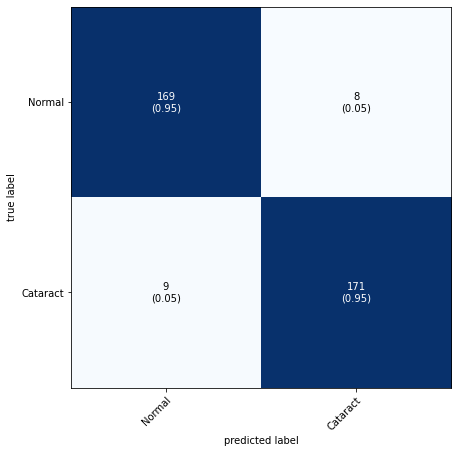

In [68]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat = cm,figsize = (8,7), class_names = ["Normal", "Cataract"],
                      show_normed = True);

>Learning Curve

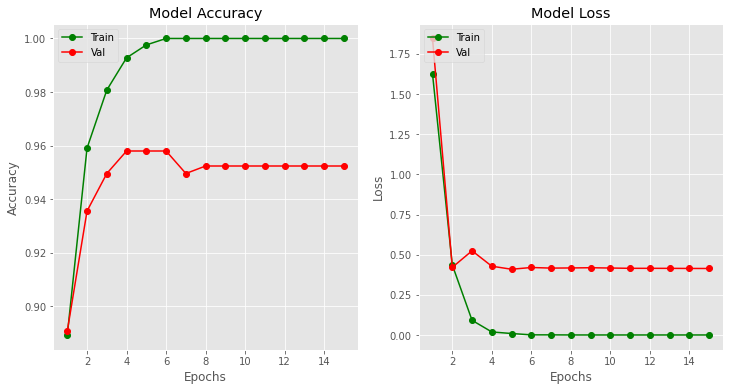

In [69]:
plt.style.use("ggplot")
fig = plt.figure(figsize = (12, 6))
epochs = range(1, 16)
plt.subplot(1, 2, 1)
plt.plot(epochs,history.history["accuracy"], "go-")
plt.plot(epochs,history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Val"], loc = "upper left")

plt.subplot(1, 2, 2)
plt.plot(epochs,history.history["loss"], "go-")
plt.plot(epochs,history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Val"], loc = "upper left")
plt.show()

>Prediction

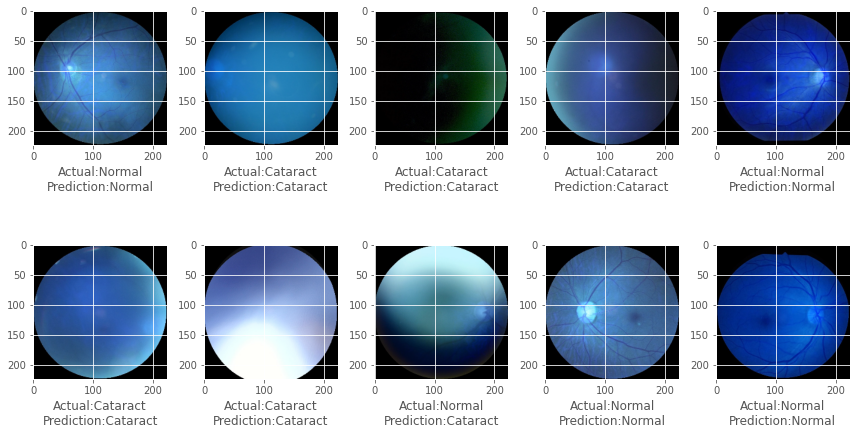

In [70]:
plt.figure(figsize = (12, 7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    if category == 0:
        label = "Normal"
    else:
        label = "Cataract"
    if pred_category == 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label, pred_label))
plt.tight_layout() 